# <center> Characterizing Machine Learning I/O Workloads on Leadership Scale HPC Systems 
## <center> [MASCOTS 2021]

In [178]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtrans


In [179]:
%reload_ext dotenv
%dotenv

In [180]:
DARSHAN_PARENT_DIR = os.getenv("DARSHAN_PARENT_DIR")
JOB_DATA_DIR = os.getenv("JOB_DATA_DIR")
DARSHAN_PROC_DATA = os.getenv("DARSHAN_PROC_DATA")

In [8]:
jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)


In [117]:
def assign_summit_job_class(df_f):
    job_node_class = [(df_f['num_nodes']<=45),
                      (df_f['num_nodes']>45)&(df_f['num_nodes']<=91),
                      (df_f['num_nodes']>91)&(df_f['num_nodes']<=921),
                      (df_f['num_nodes']>921)&(df_f['num_nodes']<=2764),
                      (df_f['num_nodes']>2764)]
    values_cl = [5,4,3,2,1]
    df_f['class'] = np.select(job_node_class,values_cl)
    return df_f 

In [118]:
def assign_summit_group(df_f):
    job_group = [(df_f['class']==5),
                      (df_f['class']==4)|(df_f['class']==3),
                      (df_f['class']==2)|(df_f['class']==1)]
    group = ['small','medium','flagship']
    df_f['group'] = np.select(job_group,group)
    return df_f

In [11]:
job_node_class = [(jobs_domainwise_df['num_nodes']<=45),
                (jobs_domainwise_df['num_nodes']>45)&(jobs_domainwise_df['num_nodes']<=91),
                (jobs_domainwise_df['num_nodes']>91)&(jobs_domainwise_df['num_nodes']<=921),
                (jobs_domainwise_df['num_nodes']>921)&(jobs_domainwise_df['num_nodes']<=2764),
                (jobs_domainwise_df['num_nodes']>2764)]


In [12]:
values_cl = ['5','4','3','2','1']
jobs_domainwise_df['Class'] = np.select(job_node_class,values_cl)


In [13]:
flagship_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='1') | (jobs_domainwise_df['Class']=='2')]
medium_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='3') | (jobs_domainwise_df['Class']=='4')]
small_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='5')]

In [21]:
#burst_buffer_jobs = jobs_domainwise_df[jobs_domainwise_df['file_system']=='Burst Buffer']

## Calculate the number of read and write bytes


#### calculate the read/write bytes of burst buffer jobs

In [ ]:

jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)

job_node_class = [(jobs_domainwise_df['num_nodes']<=45),
                (jobs_domainwise_df['num_nodes']>45)&(jobs_domainwise_df['num_nodes']<=91),
                (jobs_domainwise_df['num_nodes']>91)&(jobs_domainwise_df['num_nodes']<=921),
                (jobs_domainwise_df['num_nodes']>921)&(jobs_domainwise_df['num_nodes']<=2764),
                (jobs_domainwise_df['num_nodes']>2764)]


values_cl = ['5','4','3','2','1']
jobs_domainwise_df['Class'] = np.select(job_node_class,values_cl)
fstype_jobs = jobs_domainwise_df[jobs_domainwise_df['file_system']=='Burst Buffer']
fstype='xfs'
fstype_bytes_read = pd.DataFrame()
fstype_bytes_written = pd.DataFrame()
for i in range(fstype_jobs.shape[0]):
    date_str = datetime.strftime(datetime.strptime(fstype_jobs['job_date'].iloc[i],'%Y-%m-%d'),'%Y-%b-%d')
    date_year = date_str[0:4]
    date_month = date_str[5:8]
    date_day = int(date_str[9:11])
    jobid_ = int(fstype_jobs['jobid'].iloc[i])
    darshan_job_data = pd.read_csv(f'{DARSHAN_PARENT_DIR}/test_script/{date_month}{date_year}/{date_day}/jobwise_darshan_restructure/{jobid_}.csv')
    fstype_files_df = darshan_job_data[darshan_job_data['fstype'] == fstype]
    try:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = fstype_files_df['MPIIO_BYTES_WRITTEN']
    except KeyError:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = np.nan

    try:    
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] =  fstype_files_df['MPIIO_BYTES_READ']  
    except KeyError:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] = np.nan
    #If MPIIO bytes READ or WRITTEN are NAN, replcae with POSIX READ and WRITE
    fstype_files_df.loc[fstype_files_df['MPIIO_POSIX_AGG_BYTES_WRITTEN'].isnull(),'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = fstype_files_df['POSIX_BYTES_WRITTEN']    
    fstype_files_df.loc[fstype_files_df['MPIIO_POSIX_AGG_BYTES_READ'].isnull(),'MPIIO_POSIX_AGG_BYTES_READ'] = fstype_files_df['POSIX_BYTES_READ']
    
    fstype_bytes_read = pd.concat([fstype_bytes_read,pd.DataFrame(fstype_files_df[fstype_files_df.columns[fstype_files_df.columns.to_series().str.contains('BYTES_READ')]].sum()).transpose()],axis=0)
    fstype_bytes_written = pd.concat([fstype_bytes_written,pd.DataFrame(fstype_files_df[fstype_files_df.columns[fstype_files_df.columns.to_series().str.contains('BYTES_WRITTEN')]].sum()).transpose()],axis=0)

fstype_bytes_written['jobid'] = fstype_jobs['jobid'].values
fstype_bytes_read['jobid'] = fstype_jobs['jobid'].values

cols_order_write = fstype_bytes_written.columns.to_list()[-1:]+fstype_bytes_written.columns.to_list()[0:-1]
fstype_bytes_written = fstype_bytes_written[cols_order_write]

cols_order_read = fstype_bytes_read.columns.to_list()[-1:]+fstype_bytes_read.columns.to_list()[0:-1]
fstype_bytes_read = fstype_bytes_read[cols_order_read]

#write data because executing this cell takes long
#fstype_bytes_written.to_csv("../processed_data/bytes_written_by_ml_bb_jobs.csv",index=False)
#fstype_bytes_read.to_csv("../processed_data/bytes_read_by_ml_bb_jobs.csv",index=False)



In [12]:

write_bb_df = pd.read_csv('../processed_data/bytes_written_by_ml_bb_jobs.csv')
read_bb_df = pd.read_csv('../processed_data/bytes_read_by_ml_bb_jobs.csv')
jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)

write_bb_df['job_date'] = jobs_domainwise_df[jobs_domainwise_df['file_system']=='Burst Buffer']['job_date'].values
read_bb_df['job_date'] = jobs_domainwise_df[jobs_domainwise_df['file_system']=='Burst Buffer']['job_date'].values



### merge with jobs_domainwise_df to map jobids with domains

In [13]:
write_bb_df = write_bb_df.merge(jobs_domainwise_df.loc[:,['jobid','job_date','job_domain']])
write_bb_df = write_bb_df.fillna(0)

read_bb_df = read_bb_df.merge(jobs_domainwise_df.loc[:,['jobid','job_date','job_domain']])
read_bb_df = read_bb_df.fillna(0)

- combine read and write dataframes for plotting

In [14]:
bb_df = read_bb_df.merge(write_bb_df)
bb_df = bb_df.fillna(0)


In [16]:
#
bb_df['total_bytes_read'] = bb_df.loc[:,bb_df.columns[bb_df.columns.str.contains('READ')][:-1]].sum(axis=1)
bb_df['total_bytes_written'] = bb_df.loc[:,bb_df.columns[bb_df.columns.str.contains('WRITTEN')][:-1]].sum(axis=1)

#### Calculate read and write of GPFS Jobs
- write the results to files so that we don't have to execute the below cell again

In [17]:
jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)


In [ ]:


job_node_class = [(jobs_domainwise_df['num_nodes']<=45),
                (jobs_domainwise_df['num_nodes']>45)&(jobs_domainwise_df['num_nodes']<=91),
                (jobs_domainwise_df['num_nodes']>91)&(jobs_domainwise_df['num_nodes']<=921),
                (jobs_domainwise_df['num_nodes']>921)&(jobs_domainwise_df['num_nodes']<=2764),
                (jobs_domainwise_df['num_nodes']>2764)]


values_cl = ['5','4','3','2','1']
jobs_domainwise_df['Class'] = np.select(job_node_class,values_cl)
fstype_jobs = jobs_domainwise_df[jobs_domainwise_df['file_system']=='GPFS']
fstype='gpfs'
fstype_bytes_read = pd.DataFrame()
fstype_bytes_written = pd.DataFrame()
for i in range(fstype_jobs.shape[0]):
    print(i,end='~')
    date_str = datetime.strftime(datetime.strptime(fstype_jobs['job_date'].iloc[i],'%Y-%m-%d'),'%Y-%b-%d')
    date_year = date_str[0:4]
    date_month = date_str[5:8]
    date_day = int(date_str[9:11])
    jobid_ = int(fstype_jobs['jobid'].iloc[i])
    darshan_job_data = pd.read_csv(f'{DARSHAN_PARENT_DIR}/test_script/{date_month}{date_year}/{date_day}/jobwise_darshan_restructure/{jobid_}.csv')
    fstype_files_df = darshan_job_data[darshan_job_data['fstype'] == fstype]
    try:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = fstype_files_df['MPIIO_BYTES_WRITTEN']
    except KeyError:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = np.nan

    try:    
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] =  fstype_files_df['MPIIO_BYTES_READ']  
    except KeyError:
        fstype_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] = np.nan
    #If MPIIO bytes READ or WRITTEN are NAN, replcae with POSIX READ and WRITE
    fstype_files_df.loc[fstype_files_df['MPIIO_POSIX_AGG_BYTES_WRITTEN'].isnull(),'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = fstype_files_df['POSIX_BYTES_WRITTEN']    
    fstype_files_df.loc[fstype_files_df['MPIIO_POSIX_AGG_BYTES_READ'].isnull(),'MPIIO_POSIX_AGG_BYTES_READ'] = fstype_files_df['POSIX_BYTES_READ']
    
    fstype_bytes_read = pd.concat([fstype_bytes_read,pd.DataFrame(fstype_files_df[fstype_files_df.columns[fstype_files_df.columns.to_series().str.contains('BYTES_READ')]].sum()).transpose()],axis=0)
    fstype_bytes_written = pd.concat([fstype_bytes_written,pd.DataFrame(fstype_files_df[fstype_files_df.columns[fstype_files_df.columns.to_series().str.contains('BYTES_WRITTEN')]].sum()).transpose()],axis=0)

fstype_bytes_written['jobid'] = fstype_jobs['jobid'].values
fstype_bytes_read['jobid'] = fstype_jobs['jobid'].values

cols_order_write = fstype_bytes_written.columns.to_list()[-1:]+fstype_bytes_written.columns.to_list()[0:-1]
fstype_bytes_written = fstype_bytes_written[cols_order_write]

cols_order_read = fstype_bytes_read.columns.to_list()[-1:]+fstype_bytes_read.columns.to_list()[0:-1]
fstype_bytes_read = fstype_bytes_read[cols_order_read]

#write data because executing this cell takes long
#fstype_bytes_written.to_csv("../processed_data/bytes_written_by_ml_gpfs_jobs.csv",index=False)
#fstype_bytes_read.to_csv("../processed_data/bytes_read_by_ml_gpfs_jobs.csv",index=False)



In [18]:
write_gpfs_df = pd.read_csv("../processed_data/bytes_written_by_ml_gpfs_jobs.csv")
read_gpfs_df = pd.read_csv("../processed_data/bytes_read_by_ml_gpfs_jobs.csv")

In [19]:
#write df generated by python script batch job
#write_gpfs_df = pd.read_csv('{DARSHAN_PROC_DATA}/bytes_written_by_ml_gpfs_jobs.csv')
#read_gpfs_df = pd.read_csv('{DARSHAN_PROC_DATA}/bytes_read_by_ml_gpfs_jobs.csv')


In [20]:
write_gpfs_df = write_gpfs_df.merge(jobs_domainwise_df.loc[:,['jobid','job_date','job_domain']])
write_gpfs_df = write_gpfs_df.fillna(0)

read_gpfs_df = read_gpfs_df.merge(jobs_domainwise_df.loc[:,['jobid','job_date','job_domain']])
read_gpfs_df = read_gpfs_df.fillna(0)

In [21]:
gpfs_df = read_gpfs_df.merge(write_gpfs_df)
gpfs_df = gpfs_df.fillna(0)
gpfs_df['total_bytes_read'] = gpfs_df.loc[:,gpfs_df.columns[gpfs_df.columns.str.contains('READ')][:-1]].sum(axis=1)
gpfs_df['total_bytes_written'] = gpfs_df.loc[:,gpfs_df.columns[gpfs_df.columns.str.contains('WRITTEN')][:-1]].sum(axis=1)


In [23]:
dataset_plot_bb = bb_df.copy()
dataset_plot_bb['total_bytes_written'] = dataset_plot_bb['total_bytes_written']
dataset_plot_bb['total_bytes_read'] = dataset_plot_bb['total_bytes_read']

#convert into logscale
dataset_plot_bb['total_bytes_written'] = np.log10(dataset_plot_bb['total_bytes_written'])
dataset_plot_bb['total_bytes_read'] = np.log10(dataset_plot_bb['total_bytes_read'])




In [24]:
dataset_plot_gpfs = gpfs_df.copy()
dataset_plot_gpfs['total_bytes_written'] = dataset_plot_gpfs['total_bytes_written']
dataset_plot_gpfs['total_bytes_read'] = dataset_plot_gpfs['total_bytes_read']

#convert into logscale
dataset_plot_gpfs['total_bytes_written'] = np.log10(dataset_plot_gpfs['total_bytes_written'])
dataset_plot_gpfs['total_bytes_read'] = np.log10(dataset_plot_gpfs['total_bytes_read'])

In [30]:
density_gpfs = (dataset_plot_gpfs[(dataset_plot_gpfs['job_domain']=='Materials')| (dataset_plot_gpfs['job_domain']=='Biology')| 
         (dataset_plot_gpfs['job_domain']=='Chemistry')|(dataset_plot_gpfs['job_domain']=='Comp. Sc.')])

density_bb = (dataset_plot_bb[(dataset_plot_bb['job_domain']=='Materials')| (dataset_plot_bb['job_domain']=='Biology')| 
         (dataset_plot_bb['job_domain']=='Chemistry')|(dataset_plot_bb['job_domain']=='Comp. Sc.')])

### Density plot

/tmp/ipykernel_89/1314632464.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_yticklabels([None])


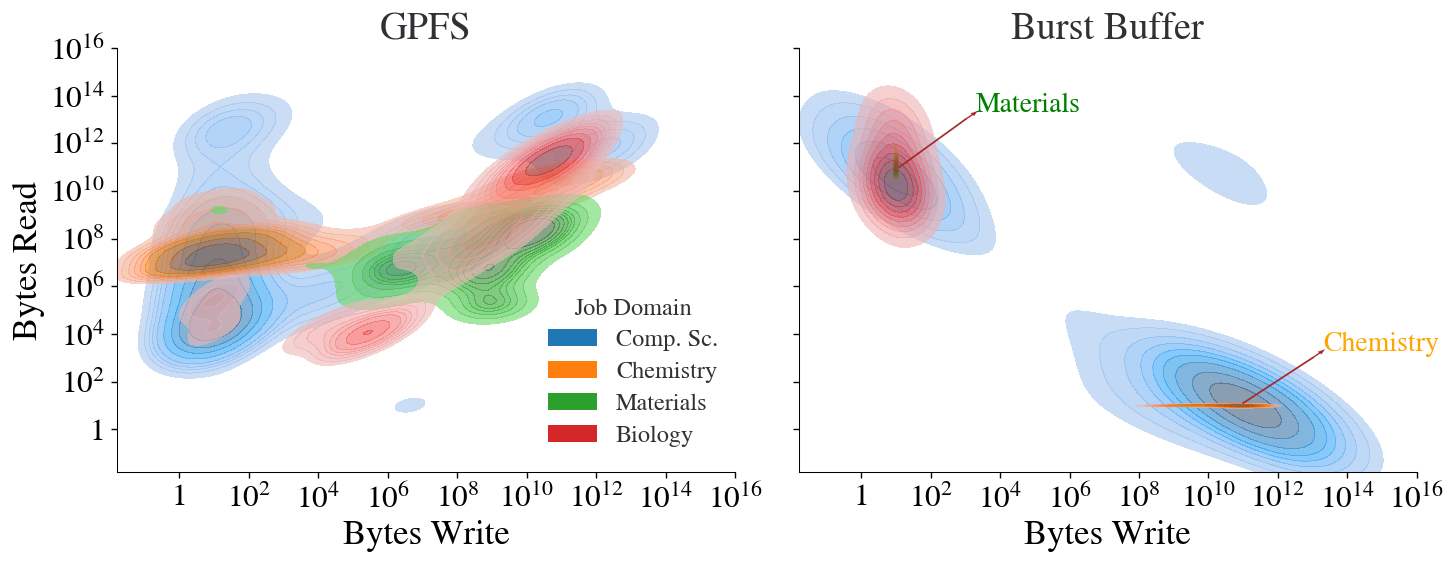

In [32]:
plt.style.use("acm_ieee_latex_pubstyle.txt")

DOUBLE_COLUMN = DOUBLE_WIDTH = 12.0
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 18, 'font.family': 'STIXGeneral', 'axes.ticksize':14})


fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*2/5))

hue_order_1 = ['Comp. Sc.','Chemistry','Materials','Biology']
hue_order_2 = ['Fusion','Engineering','Earth Sc.','Mach. Learn.','Physics']
p0 = sns.kdeplot(ax=axes[0], data=density_gpfs, x="total_bytes_written",y="total_bytes_read",hue='job_domain',
                 hue_order=hue_order_1,common_norm=False,#log_scale=(True,True),
                 fill=True,levels=10,thresh=0.2,alpha=0.6)
p0.set(ylim=(-1.8,16),xlim=(-1.8,16))

p0.set_xlabel(xlabel="Bytes Write", fontsize=20)
p0.set_ylabel(ylabel="Bytes Read", fontsize=20)
p1 = sns.kdeplot(ax=axes[1], data=density_bb, x="total_bytes_written",y="total_bytes_read",hue='job_domain',
                 hue_order=hue_order_1,common_norm=False,#log_scale=(True,True),
                 fill=True,levels=10,thresh=0.2,alpha=0.6)
p1.set(ylim=(-1.8,16),xlim=(-1.8,16))

p1.set_xlabel(xlabel="Bytes Write", fontsize=20)
p1.set_ylabel(None, fontsize=20)

tick_font_size=18
None
for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)    

for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
for tick in axes[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
    
p1.legend("")
p0.legend_.set_title("Job Domain",prop={'size':14})
p0.legend_.set_bbox_to_anchor((1, 0.45))

p0.set_xticks([0,2,4,6,8,10,12,14,16])
p0.set_xticklabels(["1","$10^2$", "$10^4$", "$10^6$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$"])
p0.set_yticks([0,2,4,6,8,10,12,14,16])
p0.set_yticklabels(["1","$10^2$", "$10^4$", "$10^6$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$"])
p1.set_xticks([0,2,4,6,8,10,12,14,16])
p1.set_xticklabels(["1","$10^2$", "$10^4$", "$10^6$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$"])
p1.set_yticklabels([None])
ann_text = ['GPFS', 'Burst Buffer']    
for ax_cnt in range(2):
    axes[ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline',
                  fontsize=22, fontweight='light',fontfamily='STIXGeneral')

p1.plot([1.1,3],[11,13],linewidth=1,color='brown')
p1.arrow(3,13,0.2,0.2,color='brown',width=0.05)
p1.text(3.3,13.3,'Materials',color='green',size=16)


p1.text(13.3,3.3,'Chemistry',color='orange',size=16)
p1.plot([11,13],[1.1,3],linewidth=1,color='brown')
p1.arrow(13,3,0.2,0.2,color='brown',width=0.05)


fig.tight_layout()
fig.savefig("../plots/density_read_write.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

### Plots for temporal analysis

In [37]:
bb_df['job_month'] = bb_df['job_date'].str[0:7]
gpfs_df['job_month'] = gpfs_df['job_date'].str[0:7]

In [38]:
combined_gpfs_bb = pd.concat([gpfs_df,bb_df],axis=0)

In [39]:
comb_mnth_wise = (combined_gpfs_bb[combined_gpfs_bb['job_domain'].isin(hue_order_1)].
          loc[:,['job_month','job_domain','total_bytes_read','total_bytes_written']].
          groupby(['job_domain','job_month']).agg('sum'))

In [41]:
all_df_temporal = (combined_gpfs_bb.loc[:,['job_month','total_bytes_read','total_bytes_written']].groupby(['job_month']).agg('sum'))
#Calculate percentage
all_df_temporal.iloc[:,0] = (all_df_temporal.iloc[:,[0]].div(all_df_temporal.iloc[:,[0]].sum(axis=0))*100)
all_df_temporal.iloc[:,1] = (all_df_temporal.iloc[:,[1]].div(all_df_temporal.iloc[:,[1]].sum(axis=0))*100)
calendar_months=['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.']
all_df_temporal.index = calendar_months
all_df_temporal.index = range(1,13)

In [43]:
#converting array into cdf array

def add_prev_elem(l):
    cum_sum = 0
    for el in l:
        cum_sum += el
        yield cum_sum

<Figure size 1000x750 with 0 Axes>

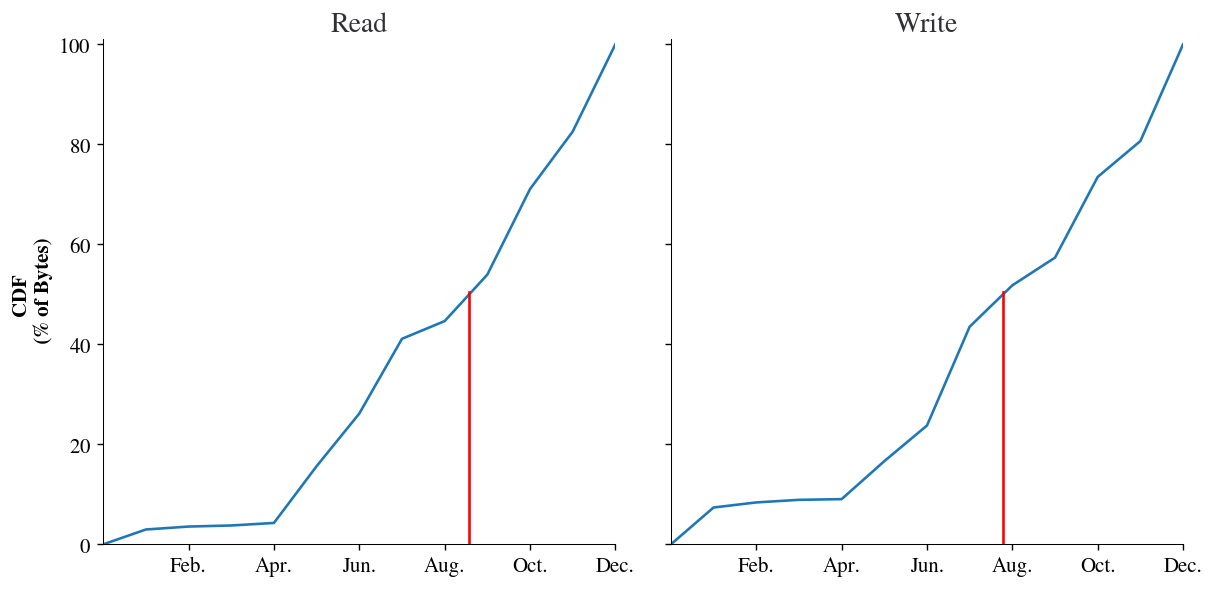

In [45]:
#%matplotlib

import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


SINGLE_COLUMN = SINGLE_WIDTH = 6.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 10.0
WEIGHT_VAR='bold'
FONTSIZE_VAR=12
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'axes.labelweight':"normal"})
sns.despine(top=False, right=False)

fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))

gs1 = gridspec.GridSpec(10, 5)
gs1.update(wspace=0.025, hspace=0.05)

plot_x_axis =list(all_df_temporal.index.values )
plot_x_axis.insert(0,0)

ylim_min=0;ylim_max=101

for i in range(len(axes)):
    el_gen = add_prev_elem(all_df_temporal.iloc[:,i].values)
    el_list = [i for i in el_gen]
    el_list.insert(0,0)

    g = sns.lineplot(x=plot_x_axis, y=el_list, ax=axes[i])
    if i == 0:
        axes[i].set_ylabel("CDF \n (% of Bytes)",fontweight=WEIGHT_VAR,
                 fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
    else:
        axes[i].set_ylabel("")
        axes[i].set_yticklabels([])
        
    axes[i].set(ylim=(ylim_min,ylim_max))
    axes[i].set(xlim=(0,12))
    #trans = mtrans.Affine2D().translate(-15, 0)
    #for t in axes[i].get_xticklabels():
    #    t.set_transform(t.get_transform()+trans)
    
    axes[i].axvline(x=np.interp(50,el_list,plot_x_axis), ymin=0.0, ymax=0.50, color='red')
    axes[i].set_xticks([2,4,6,8,10,12])
    axes[i].set_xticklabels( ['Feb.', 'Apr.', 'Jun.', 'Aug.', 'Oct.', 'Dec.'])#,rotation=90)
    
ann_text = ['Read', 'Write']
for ax_cnt in range(2):
    axes[ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5,1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline', rotation=0,
                  fontsize=16, fontweight='light',fontfamily='STIXGeneral')    
    
fig.tight_layout()
fig.savefig("../plots/temporal_cdf_high_level.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

In [52]:
domain_temporal_bb = (bb_df[bb_df['job_domain'].isin(hue_order_1)].
       loc[:,['job_month','job_domain','total_bytes_read','total_bytes_written']].
       groupby(['job_domain','job_month']).agg('sum'))

domain_temporal_gpfs = (gpfs_df[gpfs_df['job_domain'].isin(hue_order_1)].
       loc[:,['job_month','job_domain','total_bytes_read','total_bytes_written']].
       groupby(['job_domain','job_month']).agg('sum'))


### Temporal plots for GPFS and burst buffer

In [53]:
def get_read_write_bytes_monthwise_domainwise(dd_local):
    t1_read = pd.DataFrame()
    t1_write = pd.DataFrame()
    first_loop = True

    for elem in hue_order_1:
        if first_loop:
            first_loop = False
            t1_read = dd_local.xs(elem,drop_level=True).reset_index().iloc[:,[0,1]]
            t1_write = dd_local.xs(elem,drop_level=True).reset_index().iloc[:,[0,2]]

            #convert to percentage
            t1_read.iloc[:,[1]] = t1_read.iloc[:,[1]].div(t1_read.iloc[:,[1]].sum(axis=0))*100
            t1_write.iloc[:,[1]] = t1_write.iloc[:,[1]].div(t1_write.iloc[:,[1]].sum(axis=0))*100

            t1_read.columns = ['month',elem]
            t1_write.columns = ['month',elem]
        else:
            temp_df = dd_local.xs(elem,drop_level=True).reset_index().iloc[:,[0,1]].rename(columns={'job_month':'month','total_bytes_read':elem})
            temp_df.iloc[:,[1]] = temp_df.iloc[:,[1]].div(temp_df.iloc[:,[1]].sum(axis=0))*100
            t1_read = t1_read.merge(temp_df,how='outer')

            temp_df = dd_local.xs(elem,drop_level=True).reset_index().iloc[:,[0,2]].rename(columns={'job_month':'month','total_bytes_written':elem})
            temp_df.iloc[:,[1]] = temp_df.iloc[:,[1]].div(temp_df.iloc[:,[1]].sum(axis=0))*100
            t1_write = t1_write.merge(temp_df,how='outer')
    
    return [t1_read, t1_write]
    

In [54]:
t1_read, t1_write = get_read_write_bytes_monthwise_domainwise(domain_temporal_gpfs)

<Figure size 1000x750 with 0 Axes>

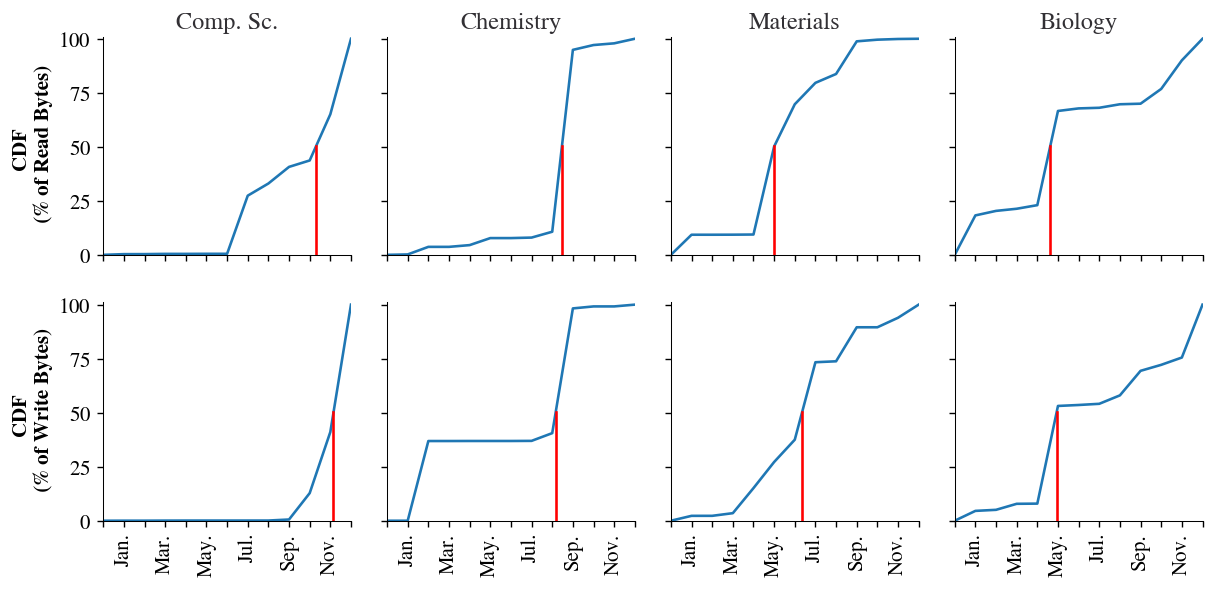

In [55]:
#%matplotlib

import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


t1_read = t1_read.fillna(0)
t1_write = t1_write.fillna(0)

SINGLE_COLUMN = SINGLE_WIDTH = 6.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 10.0
WEIGHT_VAR='bold'
FONTSIZE_VAR=12

domain_col = ["Comp. Sc.","Chemistry","Materials","Biology"]
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'axes.labelweight':"normal"})
sns.despine(top=False, right=False)

fig, axes = plt.subplots(nrows=2, ncols=4, 
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))

gs1 = gridspec.GridSpec(10, 4)
gs1.update(wspace=0.025, hspace=0.05)

plot_x_axis =list(range(1,13) )
plot_x_axis.insert(0,0)

ylim_min=0;ylim_max=101

byte_type_list = ['Read', 'Write']

dataset = [t1_read, t1_write]
for i in range(axes.shape[0]):
    cdf_df = dataset[i]
    for j in range(axes.shape[1]):
        el_gen = add_prev_elem(cdf_df.loc[:,domain_col[j]].values)
        el_list = [i for i in el_gen]
        el_list.insert(0,0)
        
        g = sns.lineplot(x=plot_x_axis, y=el_list, ax=axes[i,j])

        axes[i,j].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[i,j].xaxis.set_major_formatter(ticker.ScalarFormatter())        
        if i == 0:
            axes[i,j].set_xlabel("")
            axes[i,j].set_xticklabels([])
        else:
            axes[i,j].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axes[i,j].set_xticklabels( ['','Jan.', '','Mar.','', 'May.','', 'Jul.','', 'Sep.', '','Nov.',''],rotation=90)
            
        if j != 0:
            axes[i,j].set_ylabel("")
            axes[i,j].set_yticklabels([])            
        elif j == 0:
            axes[i,j].set_ylabel(f"CDF \n (% of {byte_type_list[i]} Bytes)",fontweight=WEIGHT_VAR,
                 fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')            

        axes[i,j].set(ylim=(ylim_min,ylim_max))
        axes[i,j].set(xlim=(0,12))
        x_point = np.interp(50,el_list,plot_x_axis)
        if x_point < 12:
            axes[i,j].axvline(x=np.interp(50,el_list,plot_x_axis), ymin=0.0, ymax=0.50, color='red')
        
ann_text = ['Comp. Sc.', 'Chemistry', 'Materials', 'Biology']    
for ax_cnt in range(4):
    axes[0,ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline',
                  fontsize=14, fontweight='light',fontfamily='STIXGeneral')  
    
fig.tight_layout()
fig.savefig("../plots/temporal_cdf_domain_gpfs.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

In [57]:
t1_read, t1_write = get_read_write_bytes_monthwise_domainwise(domain_temporal_bb)

<Figure size 1000x750 with 0 Axes>

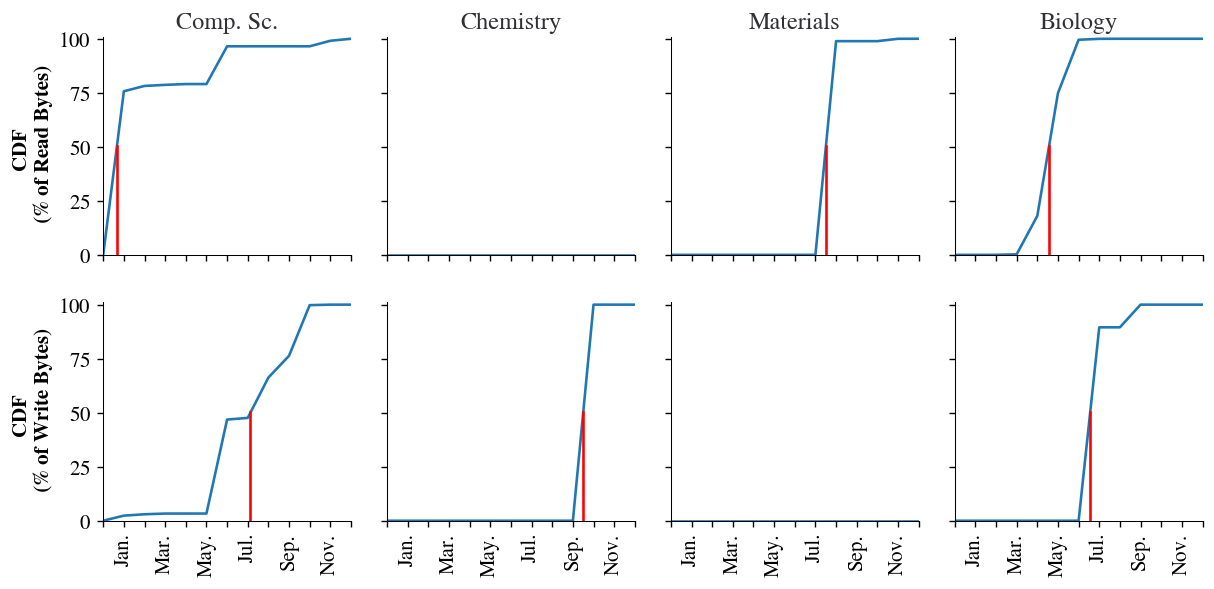

In [58]:
#%matplotlib

import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


t1_read = t1_read.fillna(0)
t1_write = t1_write.fillna(0)

SINGLE_COLUMN = SINGLE_WIDTH = 6.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 10.0
WEIGHT_VAR='bold'
FONTSIZE_VAR=12

domain_col = ["Comp. Sc.","Chemistry","Materials","Biology"]
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'axes.labelweight':"normal"})
sns.despine(top=False, right=False)

fig, axes = plt.subplots(nrows=2, ncols=4, 
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))

gs1 = gridspec.GridSpec(10, 4)
gs1.update(wspace=0.025, hspace=0.05)

plot_x_axis =list(range(1,13) )
plot_x_axis.insert(0,0)

ylim_min=0;ylim_max=101

byte_type_list = ['Read', 'Write']

dataset = [t1_read, t1_write]
for i in range(axes.shape[0]):
    cdf_df = dataset[i]
    for j in range(axes.shape[1]):
        el_gen = add_prev_elem(cdf_df.loc[:,domain_col[j]].values)
        el_list = [i for i in el_gen]
        el_list.insert(0,0)
        
        g = sns.lineplot(x=plot_x_axis, y=el_list, ax=axes[i,j])

        axes[i,j].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[i,j].xaxis.set_major_formatter(ticker.ScalarFormatter())        
        if i == 0:
            axes[i,j].set_xlabel("")
            axes[i,j].set_xticklabels([])
        else:
            axes[i,j].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axes[i,j].set_xticklabels( ['','Jan.', '','Mar.','', 'May.','', 'Jul.','', 'Sep.', '','Nov.',''],rotation=90)
            
        if j != 0:
            axes[i,j].set_ylabel("")
            axes[i,j].set_yticklabels([])            
        elif j == 0:
            axes[i,j].set_ylabel(f"CDF \n (% of {byte_type_list[i]} Bytes)",fontweight=WEIGHT_VAR,
                 fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')            

        axes[i,j].set(ylim=(ylim_min,ylim_max))
        axes[i,j].set(xlim=(0,12))
        x_point = np.interp(50,el_list,plot_x_axis)
        if x_point < 12:
            axes[i,j].axvline(x=np.interp(50,el_list,plot_x_axis), ymin=0.0, ymax=0.50, color='red')
        
ann_text = ['Comp. Sc.', 'Chemistry', 'Materials', 'Biology']    
for ax_cnt in range(4):
    axes[0,ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline',
                  fontsize=14, fontweight='light',fontfamily='STIXGeneral')  
    
fig.tight_layout()
fig.savefig("../plots/temporal_cdf_domain_bb.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

### Persisted files across BB and GPFS

#### To get persisted files, we actually find common files on GPFS and burst buffer
- We run bytes_xfs_common.py in codes directory using bytes_xfs_common.slurm files

In [80]:

burst_buffer_persist_df = pd.DataFrame()
for i in range(0,1046,50):
    try:
        bb_persist_ = pd.read_csv(f'{DARSHAN_PROC_DATA}/burst_buffer_persist_{i}.csv')
    except Exception as ex:
        print(i)
    burst_buffer_persist_df = pd.concat([burst_buffer_persist_df, bb_persist_],axis=0)

#### Find Read intensive (RI), Write Intensive (WI) and Read-Write (RW) jobs

In [73]:
#RI RW, or WI jobs
common_files_df = burst_buffer_persist_df.copy()
common_files_df['job_read_write_val'] = (common_files_df['total_bytes_read']-
                                         common_files_df['total_bytes_written'])/(common_files_df['total_bytes_read']+
                                                                                  common_files_df['total_bytes_written'])

job_read_write_val = [(common_files_df['job_read_write_val']<=-0.5),
                  (common_files_df['job_read_write_val']>-0.5)&(common_files_df['job_read_write_val']<0.5),
                  (common_files_df['job_read_write_val']>=0.5)]
values_cl = ['WI','RW','RI']
common_files_df['job_read_write_class'] = np.select(job_read_write_val,values_cl,default='NRW')
#
common_files_df = common_files_df[common_files_df['job_read_write_class']!='NRW']
common_files_df = common_files_df.groupby(['job_domain','job_read_write_class']).agg(
    count=('job_read_write_class','count')).reset_index()

In [74]:
common_files_df = common_files_df.groupby(['job_domain', 'job_read_write_class']).agg(count=('count','sum'))
common_files_df = (pd.concat([common_files_df.reset_index(),
            common_files_df.groupby(level=0)['count'].apply(lambda x:100 * x / (x.sum())).reset_index().rename(
                columns={'count':'percentage'})['percentage']],axis=1))

In [76]:
common_files_df = (
    pd.concat([common_files_df,
               pd.DataFrame({'job_domain':'Chemistry','job_read_write_class':'RI','count':0},index=[0]),
              pd.DataFrame({'job_domain':'Chemistry','job_read_write_class':'RW','count':0},index=[0]),
              pd.DataFrame({'job_domain':'Materials','job_read_write_class':'WI','count':0},index=[0]),
              pd.DataFrame({'job_domain':'Materials','job_read_write_class':'RW','count':0},index=[0])])
).reset_index(drop=True)

In [81]:
### RI/WI/RW for persisted data
persist_jobs_df = burst_buffer_persist_df.copy()

persist_jobs_df['bb_persited_read_write_val'] = (persist_jobs_df['read_bytes_bb_persisted']-\
                                                 persist_jobs_df['write_bytes_bb_persisted'])/(persist_jobs_df['read_bytes_bb_persisted']+\
                                                                                               persist_jobs_df['write_bytes_bb_persisted'])

persist_jobs_df = persist_jobs_df[~persist_jobs_df['bb_persited_read_write_val'].isna()]

job_read_write_val = [(persist_jobs_df['bb_persited_read_write_val']<=-0.5),
                  (persist_jobs_df['bb_persited_read_write_val']>-0.5)&(persist_jobs_df['bb_persited_read_write_val']<0.5),
                  (persist_jobs_df['bb_persited_read_write_val']>=0.5)]
#values_cl = ['Persist WI','Persist RW','Persist RI']
values_cl = ['WI','RW','RI']
persist_jobs_df['bb_persited_job_read_write_class'] = np.select(job_read_write_val,values_cl,default='NRW')


In [82]:
persist_jobs_df = persist_jobs_df.groupby(['job_domain','bb_persited_job_read_write_class']
                                         ).agg(count=('bb_persited_job_read_write_class','count'))
persist_jobs_df = persist_jobs_df.reset_index()

In [83]:
#filling the missing values with 0
persist_jobs_df = (pd.concat([persist_jobs_df,
           pd.DataFrame({'job_domain':'Biology','bb_persited_job_read_write_class':'RI','count':0},index=[0]),
           pd.DataFrame({'job_domain':'Biology','bb_persited_job_read_write_class':'RW','count':0},index=[0]),
           pd.DataFrame({'job_domain':'Materials','bb_persited_job_read_write_class':'WI','count':0},index=[0]),
           pd.DataFrame({'job_domain':'Materials','bb_persited_job_read_write_class':'RW','count':0},index=[0]),            
           pd.DataFrame({'job_domain':'Chemistry','bb_persited_job_read_write_class':'RI','count':0},index=[0]),            
           pd.DataFrame({'job_domain':'Chemistry','bb_persited_job_read_write_class':'WI','count':0},index=[0]),
           pd.DataFrame({'job_domain':'Chemistry','bb_persited_job_read_write_class':'RW','count':0},index=[0])],axis=0)
)

In [85]:
main_persist_df = (persist_jobs_df.rename(columns={'count':'burst_buffer'}).
                merge(common_files_df,how='inner',left_on=['job_domain','bb_persited_job_read_write_class'],
                      right_on=['job_domain','job_read_write_class']).
                sort_values(['job_domain','bb_persited_job_read_write_class'])
               )
main_persist_df['percentage_persisted'] = ((main_persist_df['burst_buffer']/main_persist_df['count'])*main_persist_df['percentage']).fillna(0)


In [86]:
#use pandas melt function for reaarranging data
persist_melt_df = pd.melt(main_persist_df,id_vars=['job_read_write_class','job_domain'],value_vars=['percentage','percentage_persisted'])
persist_melt_df['type'] = persist_melt_df['job_read_write_class'].str[0:]+'-'+persist_melt_df['variable'].str[0:]

In [90]:
#function to partially shade the plots
class GridShader():
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))
        print(locs)
        start = locs[1-int(self.sf)::2]  
        end = locs[2-int(self.sf)::2]
        print(start)
        print(end)
        start = start-0.5
        end = end-0.5
        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


[-0.5  0.   1.   2.   3.   3.5]
[0.  2.  3.5]
[1. 3.]


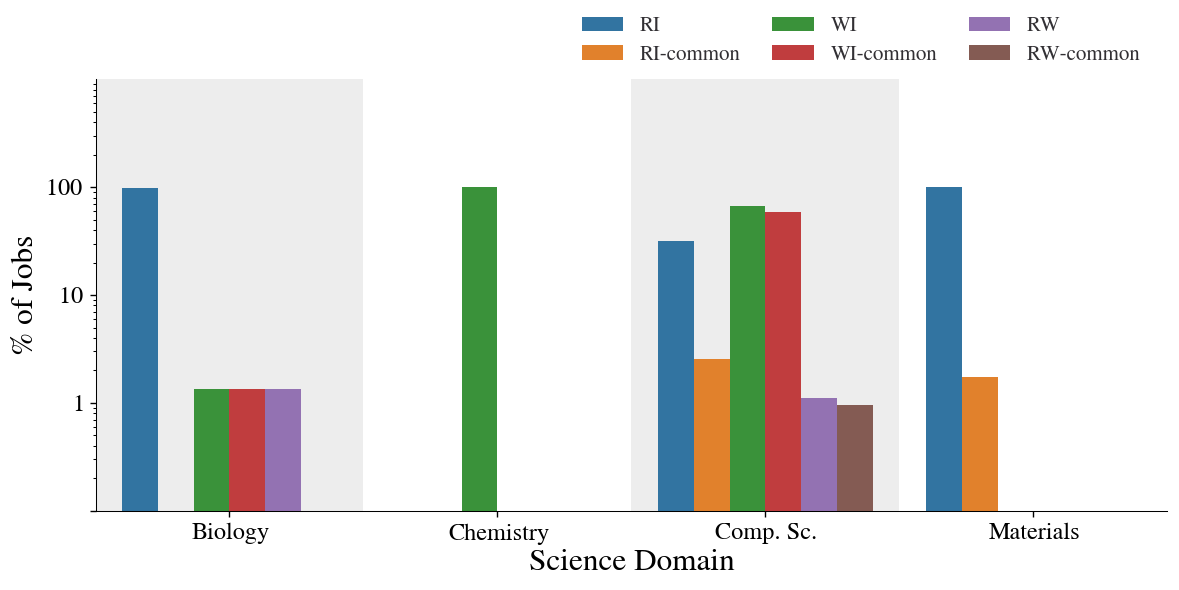

In [100]:
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 18, 'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))
g1 = sns.barplot(x='job_domain',y='value',data=persist_melt_df,hue='type',hue_order=['RI-percentage','RI-percentage_persisted',
                                                                              'WI-percentage','WI-percentage_persisted',
                                                                              'RW-percentage','RW-percentage_persisted',                                                                              
                                                                             ])#,hue_order=['RI','WI','RW'])

axes.set(ylabel="% of Jobs", xlabel="Science Domain")
axes.set(yscale='log')#, ylim=(0,120))

for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

axes.set_yticks([0.1,1,10,100])
axes.set_yticklabels(["","$1$", "$10$", "$100$"])    
trans = mtrans.Affine2D().translate(1, 0)
for t in axes.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
axes.legend(fontsize=8)

handles, labels  =  axes.get_legend_handles_labels()

axes.legend(handles, ['RI', 'RI-common', 'WI', 'WI-common', 'RW', 'RW-common'], ncol=3,bbox_to_anchor=(0.44, 1),fontsize=12)

gs = GridShader(g1, facecolor="lightgrey", first=False, alpha=0.4)
fig.tight_layout()

fig.savefig("../plots/bb_persited_domainwise.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)



#### Jobs size wise persitance

In [189]:
main_df = pd.DataFrame()
for i in range(0,1046,20):
    try:
        bb_persist_ = pd.read_csv(f'{DARSHAN_PROC_DATA}/burst_buffer_persist_{i}.csv')
    except Exception as ex:
        continue
    main_df = pd.concat([main_df, bb_persist_],axis=0)

In [157]:
jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)


In [158]:
# get jobs group based on number of nodes
jobs_domainwise_df = assign_summit_job_class(jobs_domainwise_df)
jobs_domainwise_df = assign_summit_group(jobs_domainwise_df)

In [160]:
main_df['job_date'] = main_df['job_date'].astype(str)
main_df = jobs_domainwise_df.merge(main_df)


In [161]:
ri_wi_df_scale = ri_wi_df_scale.rename(columns={'total_read':'total_bytes_read',
                              'total_write':'total_bytes_written'})

In [162]:
ri_wi_df_scale = jobs_domainwise_df.loc[:,['jobid','job_date','group']].merge(main_df.loc[:,['jobid','job_date','total_bytes_read','total_bytes_written']])
ri_wi_df_scale['ri_wi_ration'] = (ri_wi_df_scale['total_bytes_read']-ri_wi_df_scale['total_bytes_written'])/(ri_wi_df_scale['total_bytes_read']+ri_wi_df_scale['total_bytes_written'])


job_read_write_val = [(ri_wi_df_scale['ri_wi_ration']<=-0.5),
                  (ri_wi_df_scale['ri_wi_ration']>-0.5)&(ri_wi_df_scale['ri_wi_ration']<0.5),
                  (ri_wi_df_scale['ri_wi_ration']>=0.5)]

values_cl = ['WI','RW','RI']
ri_wi_df_scale['scale_read_write_class'] = np.select(job_read_write_val,values_cl,default='NRW')
ri_wi_df_scale = ri_wi_df_scale[ri_wi_df_scale['scale_read_write_class']!='NRW']


In [163]:
ri_wi_df_scale = ri_wi_df_scale.groupby(['group','scale_read_write_class']).agg(count=('scale_read_write_class','count'))#{'persisted_WI_files','sum'})
ri_wi_df_scale = ri_wi_df_scale.drop('0')


ri_wi_df_scale = (pd.concat([ri_wi_df_scale.reset_index(),
            ri_wi_df_scale.groupby(level=0)['count'].apply(lambda x:100 * x / (x.sum())).reset_index().rename(columns={'count':'percentage'})['percentage']],axis=1))
#ri_wi_df_scale = ri_wi_df_scale.reset_index()

ri_wi_df_scale = (
    pd.concat([ri_wi_df_scale,
               pd.DataFrame({'group':'flagship','scale_read_write_class':'RW','count':0, 'percentage':0},index=[0])]).reset_index(drop=True)
)
               

In [164]:
main_df['job_date'] = main_df['job_date'].astype(str)
main_df = jobs_domainwise_df.merge(main_df)

In [165]:
main_df['bb_persited_read_write_val'] = (main_df['read_bytes_bb_persisted']-main_df['write_bytes_bb_persisted'])/(main_df['read_bytes_bb_persisted']+main_df['write_bytes_bb_persisted'])

ri_wi_df_scale_persist = main_df[~main_df['bb_persited_read_write_val'].isna()]

job_read_write_val = [(ri_wi_df_scale_persist['bb_persited_read_write_val']<=-0.5),
                  (ri_wi_df_scale_persist['bb_persited_read_write_val']>-0.5)&(ri_wi_df_scale_persist['bb_persited_read_write_val']<0.5),
                  (ri_wi_df_scale_persist['bb_persited_read_write_val']>=0.5)]
#values_cl = ['Persist WI','Persist RW','Persist RI']
values_cl = ['WI','RW','RI']
ri_wi_df_scale_persist['scale_read_write_class_persist'] = np.select(job_read_write_val,values_cl,default='NRW')
ri_wi_df_scale_persist = ri_wi_df_scale_persist[ri_wi_df_scale_persist['scale_read_write_class_persist']!='NRW']

#merge to get the scale of jobs from sched logs
ri_wi_df_scale_persist = jobs_domainwise_df.merge(ri_wi_df_scale_persist)


/tmp/ipykernel_89/416811062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ri_wi_df_scale_persist['scale_read_write_class_persist'] = np.select(job_read_write_val,values_cl,default='NRW')


In [166]:
ri_wi_df_scale_persist = ri_wi_df_scale_persist.groupby(['group','scale_read_write_class_persist']).agg(count=('scale_read_write_class_persist','count'))
#
ri_wi_df_scale_persist = (pd.concat([ri_wi_df_scale_persist.reset_index(),
            ri_wi_df_scale_persist.groupby(level=0)['count'].apply(lambda x:100 * x / (x.sum())).reset_index().rename(columns={'count':'percentage_persist'})['percentage_persist']],axis=1))


In [167]:
ri_wi_df_scale_persist = (pd.concat([ri_wi_df_scale_persist.reset_index(drop=True),
           pd.DataFrame({'group':'flagship','scale_read_write_class_persist':'RI','count':0,'percentage_persist':0},index=[0]),
           pd.DataFrame({'group':'flagship','scale_read_write_class_persist':'RW','count':0,'percentage_persist':0},index=[0]),                                     
           pd.DataFrame({'group':'medium','scale_read_write_class_persist':'RW','count':0,'percentage_persist':0},index=[0])],axis=0)
).reset_index(drop=True)


In [ ]:
ri_wi_group_temp = (ri_wi_df_scale_persist.rename(columns={'count':'burst_buffer'}).
                merge(ri_wi_df_scale,how='inner',left_on=['group','scale_read_write_class_persist'],
                      right_on=['group','scale_read_write_class']).
                sort_values(['group','scale_read_write_class_persist'])
               )
ri_wi_group_temp['percentage_persisted'] = ((ri_wi_group_temp['burst_buffer']/ri_wi_group_temp['count'])*ri_wi_group_temp['percentage']).fillna(0)


In [ ]:
melt_scale_tmp = pd.melt(ri_wi_group_temp,id_vars=['scale_read_write_class','group'],value_vars=['percentage','percentage_persisted'])
melt_scale_tmp['type'] = melt_scale_tmp['scale_read_write_class'].str[0:]+'-'+melt_scale_tmp['variable'].str[0:]
melt_scale_tmp

/tmp/ipykernel_89/144629814.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set(yscale='log', ylim=(0,120))


[-0.5  0.   1.   2.   2.5]
[0. 2.]
[1.  2.5]


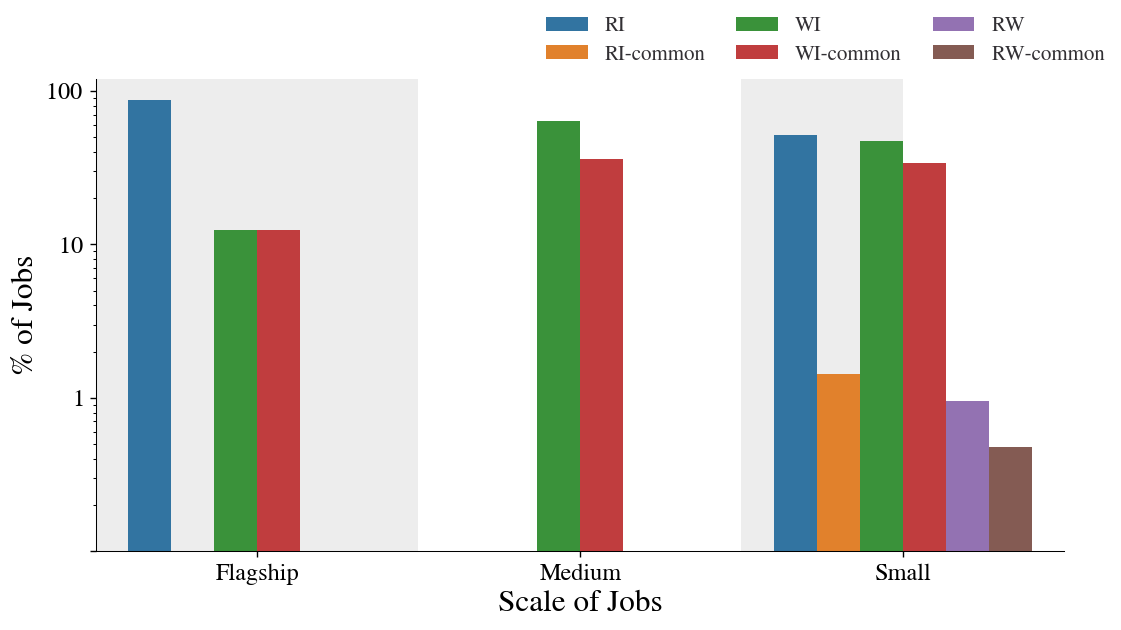

In [172]:

sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 18, 'font.family': 'STIXGeneral'})


fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))
g1 = sns.barplot(x='group',y='value',data=melt_scale_tmp,hue='type',hue_order=['RI-percentage','RI-percentage_persisted',
                                                                              'WI-percentage','WI-percentage_persisted',
                                                                              'RW-percentage','RW-percentage_persisted',                                                                              
                                                                             ])#,hue_order=['RI','WI','RW'])
axes.set(ylabel="% of Jobs", xlabel="Scale of Jobs")
axes.set(yscale='log', ylim=(0,120))
    
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

axes.set_yticks([0.1,1,10,100])
axes.set_yticklabels(["","$1$", "$10$", "$100$"])    
trans = mtrans.Affine2D().translate(1, 0)
for t in axes.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
axes.legend(fontsize=8)

handles, labels  =  axes.get_legend_handles_labels()

axes.legend(handles, ['RI', 'RI-common', 'WI', 'WI-common', 'RW', 'RW-common'], ncol=3,bbox_to_anchor=(0.45, 1),fontsize=12)


axes.set_xticklabels( ['Flagship','Medium', 'Small'])

gs = GridShader(g1, facecolor="lightgrey", first=False, alpha=0.4)

fig.savefig("../plots/job_scale_common.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)



### Bytes Persisted

In [222]:
main_df = pd.DataFrame()
for i in range(0,1046,20):
    try:
        bb_persist_ = pd.read_csv(f'{DARSHAN_PROC_DATA}/bb_bytes_read_write/burst_buffer_bytes_read_write_{i}.csv')
    except Exception as ex:
        continue
    main_df = pd.concat([main_df, bb_persist_],axis=0)
    
main_df = main_df.reset_index(drop=True)


In [ ]:
jobs_domainwise_df = pd.read_csv("{DARSHAN_PROC_DATA}/calculated_jobs_for_domain_fsType.csv",index_col=None)
jobs_domainwise_df = assign_summit_group(assign_summit_job_class(jobs_domainwise_df)) #functions are defined on the top


In [231]:
jobs_domainwise_bb_df = jobs_domainwise_df[jobs_domainwise_df['file_system']=='Burst Buffer']

In [ ]:
jobs_domainwise_bb_df

In [241]:
main_df = main_df.drop(labels=['job_date'], axis=1).merge(jobs_domainwise_bb_df)

In [242]:
plot_df = main_df.copy()
t1_d = plot_df.loc[:,['job_domain','total_write']]
t1_d = t1_d.rename(columns={'total_write':'bytes_written'})
t1_d['type'] = 'Total bytes written'

t2_d = plot_df.loc[:,['job_domain','xfs_write_val']]
t2_d = t2_d.rename(columns={'xfs_write_val':'bytes_written'})
t2_d['type'] = 'Burst buffer bytes written'

t3_d = plot_df.loc[:,['job_domain','common_write']]
t3_d = t3_d.rename(columns={'common_write':'bytes_written'})
t3_d['type'] = 'Persisted bytes written'
pl_df_write = pd.concat([t1_d,t2_d,t3_d],axis=0)
pl_df_write['bytes_written'] = np.log10(pl_df_write['bytes_written']+np.random.normal(10,1,pl_df_write.shape[0]))


plot_df = main_df.copy()

t1_d = plot_df.loc[:,['job_domain','total_read']]
t1_d = t1_d.rename(columns={'total_read':'bytes_read'})
t1_d['type'] = 'Total bytes read'

t2_d = plot_df.loc[:,['job_domain','xfs_read_val']]
t2_d = t2_d.rename(columns={'xfs_read_val':'bytes_read'})
t2_d['type'] = 'Burst buffer bytes read'

t3_d = plot_df.loc[:,['job_domain','common_read']]
t3_d = t3_d.rename(columns={'common_read':'bytes_read'})
t3_d['type'] = 'Persisted bytes read'
pl_df_read = pd.concat([t1_d,t2_d,t3_d],axis=0)
#pl_df_read['bytes_read'] = np.log10(pl_df_read['bytes_read']+1)
pl_df_read['bytes_read'] = np.log10(pl_df_read['bytes_read']+np.random.normal(10,1,pl_df_read.shape[0]))


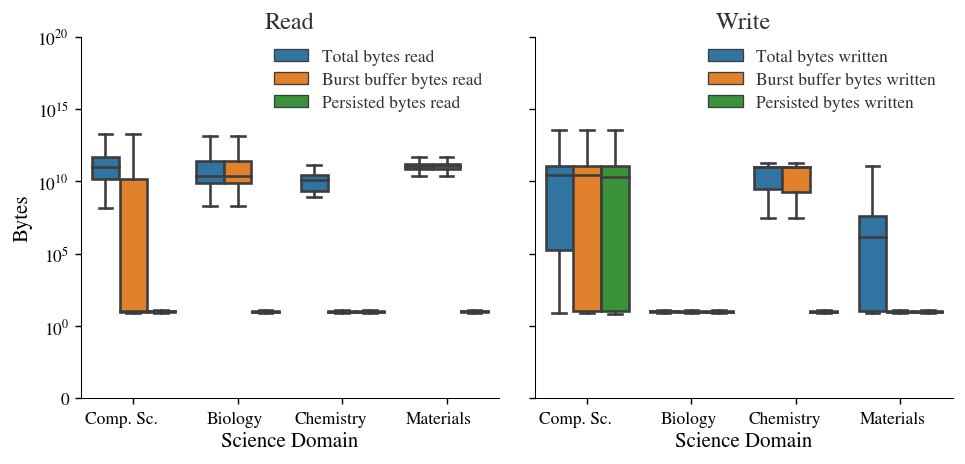

In [245]:
plt.style.use("acm_ieee_latex_pubstyle.txt")
import seaborn as sns


blue, orange = sns.color_palette('deep', n_colors=2)
DOUBLE_COLUMN = DOUBLE_WIDTH = 8.0
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'font.family': 'STIXGeneral'})


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))

for i in range(len(axes)):
    y_var = [ "bytes_read", "bytes_written"]
    y_label = ["Bytes", ""]
    df_list = [pl_df_read, pl_df_write]
        
    g = sns.boxplot(ax = axes[i], x="job_domain", y=y_var[i], hue='type',
                       data=df_list[i], showfliers=False)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), 
                         rotation=0, 
                         horizontalalignment='right')
    axes[i].set(ylabel=y_label[i], xlabel="Science Domain",ylim=(-5,20))
    for tick in axes[i].xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in axes[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(10)

    trans = mtrans.Affine2D().translate(25, 0)
    for t in axes[i].get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    if i == 0:
        axes[i].set_yticks([-5,0,5,10,15,20])
        axes[i].set_yticklabels(["0","$10^0$", "$10^5$", "$10^{10}$", "$10^{15}$", "$10^{20}$"])                
    else:
        axes[i].set_yticklabels([])
    axes[i].legend(ncol=1,bbox_to_anchor=(0.99, 1),fontsize=10)

ann_text = ['Read', 'Write']    
for ax_cnt in range(2):
    axes[ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline',
                  fontsize=14, fontweight='light',fontfamily='STIXGeneral')


fig.tight_layout()
fig.savefig("../plots/bytes_read_write_burst_buffer.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)
#
